 - __Import base modules__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

 - __Import sklearn modules__

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


 - __Import the spam/ham dataset__

In [3]:
url="https://raw.githubusercontent.com/arimitramaiti/datasets/master/Classification/spam_ham_text_classification.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0)
dataset.head(4)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...


 - __Check if missing values exist__

In [4]:
dataset.isnull().sum()

Category    0
Message     0
dtype: int64

 - __Check proportion of class values__
 - __Yes, fair imbalance exists__

In [5]:
dataset.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

 - __Check if NaN values are there and if yes then collect row indices__

In [6]:
blanks = []
for index, label, review in dataset.itertuples():
    if type(review)==str:
        if review.isspace():
            blanks.append(index)
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


 - __Create X and y attrs__

In [7]:
X, y = dataset['Message'], dataset['Category']
sdict = {'spam': 1, 'ham': 0}
y = y.map(sdict)
X.shape, y.shape

((5572,), (5572,))

 - __Read glove pre trained data file glove.6B.100d.txt__
 - https://nlp.stanford.edu/projects/glove/
 - __Code credits to transform into features : StackOverflow__
 - __Other glove files which can be used are glove.6B.50d, glove.6B.200d, glove.6B.300d, glove.840B.300d__

In [8]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return word_to_vec_map
word_to_vec_map = read_glove_vecs('glove.6B.100d.txt')

In [9]:
from tqdm import tqdm_notebook
from tqdm import tqdm

In [10]:
def prepare_sequence(ds, word_to_vec_map):
    df = []
    for sentence in tqdm(ds.values):
        sequence_words = np.zeros((100,))
        for word in sentence.split():
            if word in word_to_vec_map.keys():
                temp_X = word_to_vec_map[word]
            else:
                temp_X = word_to_vec_map['#']
            sequence_words+=(temp_X)/len(sentence)
        df.append(sequence_words)
    return np.array(df)

In [11]:
X_w2v = prepare_sequence(X, word_to_vec_map)

100%|███████████████████████████████████████████████████████████████████████████| 5572/5572 [00:00<00:00, 23269.58it/s]


In [12]:
X_w2v.shape

(5572, 100)

 - __Create training and testing datasets__

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.30, stratify=y, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3900, 100), (1672, 100), (3900,), (1672,))

In [14]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 523
Before OverSampling, counts of label '0': 3377 



 - __Apply SMOTE to uplift class imbalance only in training data__

In [15]:
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [16]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))
X_train_res.shape, X_test.shape, y_train_res.shape, y_test.shape

After OverSampling, counts of label '1': 3377
After OverSampling, counts of label '0': 3377


((6754, 100), (1672, 100), (6754,), (1672,))

 - __Import Light GBM module__

In [17]:
import lightgbm as lgb

 - __Declare estimator__

In [18]:
estimator = lgb.LGBMClassifier(boosting_type ="goss", random_state=1)

 - __Declare a decimal range of learning rates__
 - __Declare a range of tree counts__
 - __Declare a set of max depth values__
 - __Declare a set of minimum child weight__
 - __Declare a set of sample proportions to be used in attribute sampling__
 - __Create dictionary which is a must for Random Search function__

In [19]:
learning_rate = np.arange(0.01,1,0.05)
n_estimators = np.arange(100, 500, 50)
max_depth = [2, 5, 10, 20, 30, 40, 50]
min_child_weight = [1,3,6]
colsample_bytree = [0.1, 0.5, 0.8, 1]
num_leaves = [300, 900, 1200]

param_grid = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'colsample_bytree': colsample_bytree,
              'num_leaves': num_leaves}

 - __Instantiate the RandomizedSearchCV object with accuracy as scoring metric__
 - __Push the parameter dictionary inside the object__

In [20]:
randomized_accuracy_fit = RandomizedSearchCV(estimator=estimator,
                                            param_distributions=param_grid,
                                            n_iter=50,
                                            scoring="accuracy",
                                            n_jobs=-1,
                                            refit=True,
                                            random_state=123,
                                            return_train_score=True,
                                            verbose=1,
                                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
                                            )

 - __Fit the RandomizedSearchCV object on X_train & y_train__

In [21]:
training_start = time.perf_counter()
randomized_accuracy_fit.fit(X_train_res, y_train_res)
training_end = time.perf_counter()
lgb_train_time = training_end-training_start
print("Time consumed for training: %4.3f seconds" % (lgb_train_time))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.7s
C:\Users\Debjani\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished


Time consumed for training: 288.812 seconds


 - __Print the best score found by RandomizedSearchCV__
 - __Print the best model found by RandomizedSearchCV__

In [22]:
print(randomized_accuracy_fit.best_score_)
print(randomized_accuracy_fit.best_estimator_)

0.9853410037256192
LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.21000000000000002,
               max_depth=30, min_child_samples=20, min_child_weight=1,
               min_split_gain=0.0, n_estimators=250, n_jobs=-1, num_leaves=900,
               objective=None, random_state=1, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


 - __Store the best model in an object__
 - __Create predictions from the best model__

In [23]:
best_estimator = randomized_accuracy_fit.best_estimator_
prediction_start = time.perf_counter()
y_pred = best_estimator.predict(X_test)
prediction_end = time.perf_counter()
lgb_prediction_time = prediction_end-prediction_start
print("Time consumed for prediction: %6.5f seconds" % (lgb_prediction_time))

Time consumed for prediction: 0.02701 seconds


 - __Calculate Accuracy and Recall Scores__
 - __Print the respective values__
 - __Create confusion matrix and print it using heatmap__

The accuracy score for the model is: 0.969
The recall score for the model is: 0.927
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1448
           1       0.89      0.87      0.88       224

    accuracy                           0.97      1672
   macro avg       0.94      0.93      0.93      1672
weighted avg       0.97      0.97      0.97      1672



Text(91.68, 0.5, 'Actual')

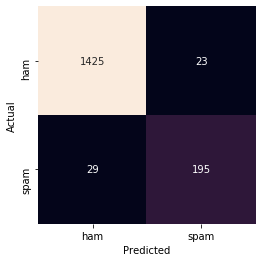

In [24]:
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred, average="macro"), 3)
cre = classification_report(y_test,y_pred)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
print(cre)
met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False, xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")